In [118]:
base = '/home2/ebrahim/beyond-brainscore/'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
from plotting_functions import plot_test_perf_across_layers, plot_across_subjects, save_fMRI_simple, single_seed_metrics, find_rows_without_nan, pass_info_plot_hist2d
from untrained_results_funcs import compute_p_val, arrange_pvals_pd, clip_neg_perf, voxel_corrected_LLM_nested_full, mse_max_model, pool_across_seeds
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import brainio
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
import pandas as pd

In [121]:
data_path = '/data/LLMs/data_processed/pereira/dataset/'
llm_acts_path = '/data/LLMs/data_processed/pereira/LLM_acts/'
results_path = '/data/LLMs/brainscore/results_pereira/untrained/'
general_res_path = '/data/LLMs/brainscore/results_pereira/'
figurePath = '/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/pereira_untrained_updated/'

N = 10

exp = ['243', '384']
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{data_path}networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'{general_res_path}mse_intercept_{e}.npy')
    ytest_dict[e] = np.load(f'{general_res_path}y_test_ordered_{e}.npy')
    subjects_dict[e] = np.load(f"{data_path}/subjects_{e}.npy", allow_pickle=True)

In [122]:
def load_best_layer(exp, model_name, N):
    best_layer_lang = []
    best_layer_lang_pearson = []
    for i in range(N):
        keys = list(dict(np.load(f'{llm_acts_path}X_{model_name}-{exp}_m{i}.npz')).keys())
        bil_lang = [k for k in keys if 'lang' in k and 'pearson' not in k][0]
        bil_lang_pearson = [k for k in keys if 'lang_pearson' in k][0]
        best_layer_lang.append(bil_lang.replace('_lang', ''))
        best_layer_lang_pearson.append(bil_lang_pearson.replace('_lang_pearson', ''))
    
        
    return best_layer_lang, best_layer_lang_pearson

In [123]:
# load non LLM related models


In [132]:
model_name = 'gpt2-xl-untrained'
sp_str = ''
model_name = f"{model_name}{sp_str}"
load_pearson_model = True

bl_lang_243, bl_lang_pearson_243 = load_best_layer('243', model_name, N)
bl_lang_384, bl_lang_pearson_384 = load_best_layer('384', model_name, N)

if load_pearson_model:
    best_layer_243 = bl_lang_pearson_243
    best_layer_384 = bl_lang_pearson_384
    pearson_r = True
    perf_metric = 'perf'
    clip_neg = False
else:
    best_layer_243 = bl_lang_243
    best_layer_384 = bl_lang_384
    pearson_r = False
    perf_metric = 'perf'
    clip_neg = True

# load LLM scores
mse_bil_243, perf_bil_243 = pool_across_seeds(ytest_dict['243'],np.repeat(model_name, N), np.repeat('243', N), 
                                              best_layer_243, niters=np.repeat(1,N), resultsFolder=results_path, pearson_r=pearson_r)
mse_bil_384, perf_bil_384 = pool_across_seeds(ytest_dict['384'],np.repeat(model_name, N), np.repeat('384', N), 
                                              best_layer_384, niters=np.repeat(1,N), resultsFolder=results_path, pearson_r=pearson_r)

mse_bil_PW_243, perf_bil_PW_243 = pool_across_seeds(ytest_dict['243'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_POSWN_243', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)
mse_bil_PW_384, perf_bil_PW_384 = pool_across_seeds(ytest_dict['384'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_POSWN_384', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)

mse_bil_W_243, perf_bil_W_243 = pool_across_seeds(ytest_dict['243'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_WN_243', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)
mse_bil_W_384, perf_bil_W_384 = pool_across_seeds(ytest_dict['384'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_WN_384', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)

mse_bil_P_243, perf_bil_P_243 = pool_across_seeds(ytest_dict['243'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_POS_243', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)
mse_bil_P_384, perf_bil_P_384 = pool_across_seeds(ytest_dict['384'],np.repeat(f'gpt2-xl-ut{sp_str}_bil-lang_POS_384', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=results_path, seed_last=False, pearson_r=pearson_r)



In [133]:
mse_W_243, perf_W_243 = single_seed_metrics(ytest_dict['243'], 'word-num', niters=1, exp='243', layer_name='layer1', 
                                                   resultsFolder=general_res_path, pearson_r=True)
mse_W_384, perf_W_384 = single_seed_metrics(ytest_dict['384'], 'word-num', niters=1, exp='384', 
                                                   layer_name='layer1', resultsFolder=general_res_path, pearson_r=True)
mse_P_243, perf_P_243 = single_seed_metrics(ytest_dict['243'], 'positional_simple', niters=1, exp='243', layer_name='layer1', 
                                                   resultsFolder=general_res_path, pearson_r=True)
mse_P_384, perf_P_384 = single_seed_metrics(ytest_dict['384'], 'positional_simple', niters=1, exp='384', 
                                                   layer_name='layer1', resultsFolder=general_res_path, pearson_r=True)
mse_PW_384, perf_PW_384 = single_seed_metrics(ytest_dict['384'], 'positional_WN', niters=1000, exp='384', 
                                                   layer_name='layer1', resultsFolder=general_res_path, pearson_r=True)
mse_PW_243, perf_PW_243 = single_seed_metrics(ytest_dict['243'], 'positional_WN', niters=1000, exp='243', 
                                                   layer_name='layer1', resultsFolder=general_res_path, pearson_r=True)

In [134]:
# store r2 valeus into a pd dataframe
model_names = ['SL', 'SP', 'SP+SL', 'GPT2-XLU', 'SL+GPT2-XLU', 'SP+GPT2-XLU', 'SP+SL+GPT2-XLU']
best_DEM_model = model_names[2]
best_LLM_model = model_names[-1]
LLM_name = model_names[3]
num_models = len(model_names)
voxels_ids_243 = np.tile(np.arange(num_vox_dict['243']), num_models)
br_labels_243 = np.tile(br_labels_dict['243'], num_models)
model_order_243 = np.repeat(np.array(model_names), num_vox_dict['243'])

perf_stacked_243 = np.concatenate((perf_W_243, perf_P_243, perf_PW_243, perf_bil_243, perf_bil_W_243, perf_bil_P_243, perf_bil_PW_243))
perf_stacked_pd_243 = pd.DataFrame({'Model': model_order_243, perf_metric:perf_stacked_243, 'voxel_id': voxels_ids_243, 
                                  'Network': br_labels_243, 'subjects': np.tile(subjects_dict['243'], num_models)}).dropna()


voxels_ids_384 = np.tile(np.arange(num_vox_dict['384']), num_models)
br_labels_384 = np.tile(br_labels_dict['384'], num_models)
model_order_384 = np.repeat(np.array(model_names), num_vox_dict['384'])
perf_stacked_384 = np.concatenate((perf_W_384, perf_P_384, perf_PW_384, perf_bil_384, perf_bil_W_384, perf_bil_P_384, perf_bil_PW_384))

perf_stacked_pd_384 = pd.DataFrame({'Model': model_order_384, perf_metric:perf_stacked_384, 'voxel_id': voxels_ids_384, 
                                   'Network': br_labels_384, 
                                   'subjects': np.tile(subjects_dict['384'], num_models)}).dropna()


network_order=['language', 'DMN', 'MD', 'visual']

In [135]:
perf_stacked_pd_243.head()

,Model,perf,voxel_id,Network,subjects
1,SL,0.078164,1,language,018
2,SL,0.147664,2,language,018
3,SL,0.088938,3,language,018
4,SL,0.097202,4,language,018
5,SL,0.088906,5,language,018


In [136]:
LLM_name = 'GPT2-XLU'
non_LLM_name = 'SP+SL'
full_name = 'SP+SL+GPT2-XLU'

BL_mod_384, non_BL_mod_384, full_mod_384 = \
            voxel_corrected_LLM_nested_full(perf_stacked_pd_384, LLM_name, non_LLM_name, full_name, clip_neg=clip_neg)
            
BL_mod_243, non_BL_mod_243, full_mod_243 = \
            voxel_corrected_LLM_nested_full(perf_stacked_pd_243, LLM_name, non_LLM_name, full_name, clip_neg=clip_neg)

/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/untrained_results_funcs.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/untrained_results_funcs.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
modified_384 = pd.concat((non_BL_mod_384, full_mod_384, BL_mod_384))
modified_243 = pd.concat((non_BL_mod_243, full_mod_243, BL_mod_243))
default_palette = sns.color_palette("deep")

<Figure size 640x480 with 0 Axes>

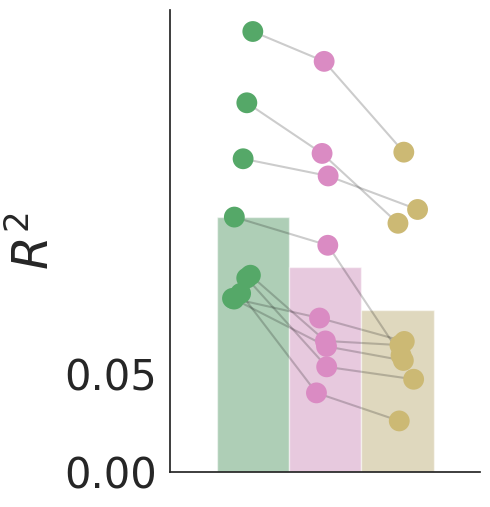

<Figure size 640x480 with 0 Axes>

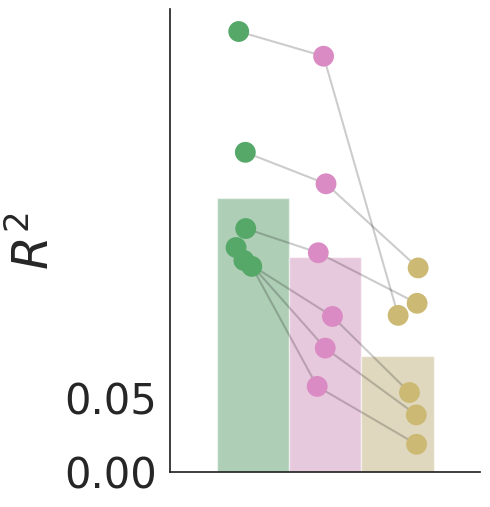

LAST TOKEN POOLING + R, TOP IS 384


In [139]:
_, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=None, hue_order=[non_LLM_name, full_name, LLM_name], 
                                             yticks=[0,0.05], order=['language'], clip_zero=clip_neg, color_palette=[default_palette[2], 
                                             default_palette[6], default_palette[8]], draw_lines=True, ms=15, width=0.7)

_, _, _ = plot_across_subjects(modified_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=None, hue_order=[non_LLM_name, full_name, LLM_name], 
                                             yticks=[0,0.05], order=['language'], clip_zero=clip_neg, color_palette=[default_palette[2], 
                                             default_palette[6], default_palette[8]], draw_lines=True, ms=15, width=0.7)

print("LAST TOKEN POOLING + R, TOP IS 384")

In [ ]:
_, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=None, hue_order=[non_LLM_name, full_name], 
                                             yticks=[0,0.05], order=['language'], clip_zero=True, color_palette=[default_palette[2], 
                                             default_palette[6]], draw_lines=True, ms=15, width=0.7)